In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
mlm_ckpts_to_eval = [10000,20000,60000,150000,290000,430000,440000]
mtr_ckpts_to_eval = [2500,10000,17500,37500,187500,275000,547500]

In [16]:
def get_pretrain_step_to_pretrain_loss(ckpt_json, ckpts_to_eval):
	step_to_loss = {}
	for ckpt in ckpt_json["log_history"]:
		if int(ckpt["step"]) in ckpts_to_eval:
			try:
				step_to_loss[int(ckpt["step"])] = ckpt["eval_loss"]
			except:
				continue

    
	return step_to_loss

model_dir = "" # TODO: fill in with appropriate model dir based on user
mlm_pretrain_loss = get_pretrain_step_to_pretrain_loss(json.load(os.path.join(model_dir,"mlm_pretraining_5M_20210722/run_45/checkpoint-440000/trainer_state.json")), mlm_ckpts_to_eval)
mtr_pretrain_loss = get_pretrain_step_to_pretrain_loss(json.load(os.path.join(model_dir,"mtr_pretraining_5M_20210804/run_45/checkpoint-547500/trainer_state.json")), mtr_ckpts_to_eval)

In [54]:
def get_pretrain_ckpt_to_finetune_loss(finetune_subdir, ckpts_to_eval, pretrain_losses, subdir=""):
	ckpts = []
	eval_set = []
	metric = []
	value = []
	#pretrain_run = []
	pretrain_loss = []

	for ckpt in ckpts_to_eval:
		results_dir = os.path.join(f"{finetune_subdir}_run_45_ckpt_{ckpt}", subdir, "results")
		for item_eval_type in ["valid", "test"]:
			for seed, res in json.load(open(f"{results_dir}/{item_eval_type}/metrics.json")).items():
				for item_metric, item_val in res.items():
					if item_metric == "pearsonr":
						item_val = item_val[0]
					ckpts.append(ckpt)
					eval_set.append(item_eval_type)
					metric.append(item_metric)
					value.append(item_val)
					#pretrain_run.append(pretrain_dir)
					pretrain_loss.append(pretrain_losses[ckpt])

	return pd.DataFrame(dict(zip(["pretrain_ckpt", "eval_set", "metric", "value", "pretrain_loss"], [ckpts, eval_set, metric, value, pretrain_loss])))

In [65]:
def make_finetune_plots(finetune_dir, metric, finetune_task, subtask=""):
	
	#MLM
	pretrain_task = "mlm"
	finetune_subdir = f"{finetune_dir}/{pretrain_task}"
	finetune_res = get_pretrain_ckpt_to_finetune_loss(finetune_subdir, mlm_ckpts_to_eval, mlm_pretrain_loss, subtask)

	# By loss
	f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey="row")
	for i, eval_type in enumerate(["valid", "test"]):
		subgroup = finetune_res[(finetune_res["eval_set"] == eval_type) & (finetune_res["metric"] == metric)] # 
		sns.regplot(data=subgroup, x="pretrain_loss", y="value", fit_reg=True, ax=axes[i])
		axes[i].set_ylabel(f"{finetune_task} {metric}")
		axes[i].set_xlabel(f"{pretrain_task} pretrain loss")
		axes[i].set_title(eval_type)
	plt.suptitle(f"{pretrain_task} pretrain - {finetune_task} finetune")
	f.tight_layout()
	plt.show()

	# By step
	f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey="row")
	for i, eval_type in enumerate(["valid", "test"]):
		subgroup = finetune_res[(finetune_res["eval_set"] == eval_type) & (finetune_res["metric"] == metric)] # 
		sns.regplot(data=subgroup, x="pretrain_ckpt", y="value", fit_reg=True, ax=axes[i], logx=True)
		axes[i].set_ylabel(f"{finetune_task} {metric}")
		axes[i].set_xlabel(f"# {pretrain_task} pretrain steps")
		axes[i].set_title(eval_type)
	plt.suptitle(f"{pretrain_task} pretrain - {finetune_task} finetune")
	f.tight_layout()
	plt.show()

	#MTR
	pretrain_task="mtr"
	finetune_subdir = f"{finetune_dir}/{pretrain_task}"
	finetune_res = get_pretrain_ckpt_to_finetune_loss(finetune_subdir, mtr_ckpts_to_eval, mtr_pretrain_loss, subtask)

	# By loss
	f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey="row")
	for i, eval_type in enumerate(["valid", "test"]):
		subgroup = finetune_res[(finetune_res["eval_set"] == eval_type) & (finetune_res["metric"] == metric)] # 
		sns.regplot(data=subgroup, x="pretrain_loss", y="value", fit_reg=True, ax=axes[i])
		axes[i].set_ylabel(f"{finetune_task} {metric}")
		axes[i].set_xlabel(f"{pretrain_task} pretrain loss")
		axes[i].set_title(eval_type)
	plt.suptitle(f"{pretrain_task} pretrain - {finetune_task} finetune")
	f.tight_layout()
	plt.show()

	# By step
	f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey="row")
	for i, eval_type in enumerate(["valid", "test"]):
		subgroup = finetune_res[(finetune_res["eval_set"] == eval_type) & (finetune_res["metric"] == metric)] # 
		sns.regplot(data=subgroup, x="pretrain_ckpt", y="value", fit_reg=True, ax=axes[i], logx=True)
		axes[i].set_ylabel(f"{finetune_task} {metric}")
		axes[i].set_xlabel(f"# {pretrain_task} pretrain steps")
		axes[i].set_title(eval_type)
	plt.suptitle(f"{pretrain_task} pretrain - {finetune_task} finetune")
	f.tight_layout()
	plt.show()

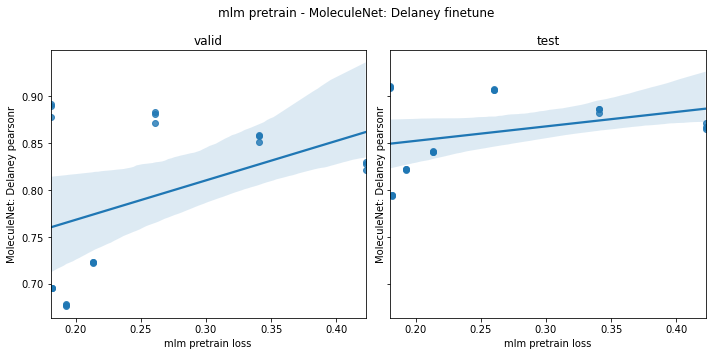

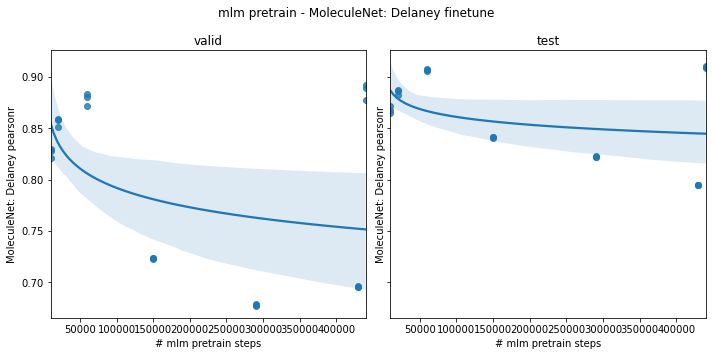

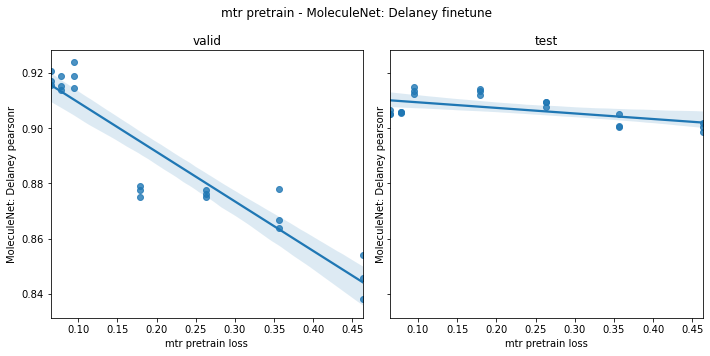

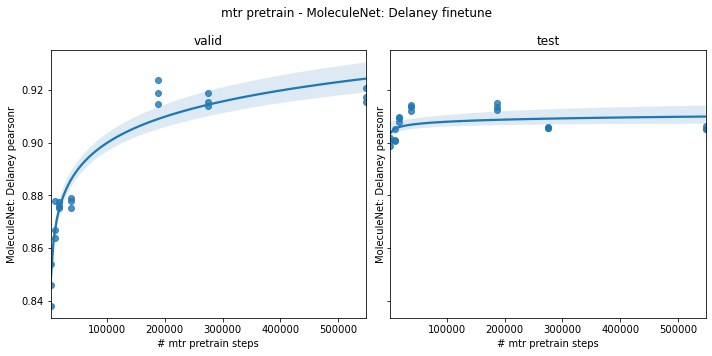

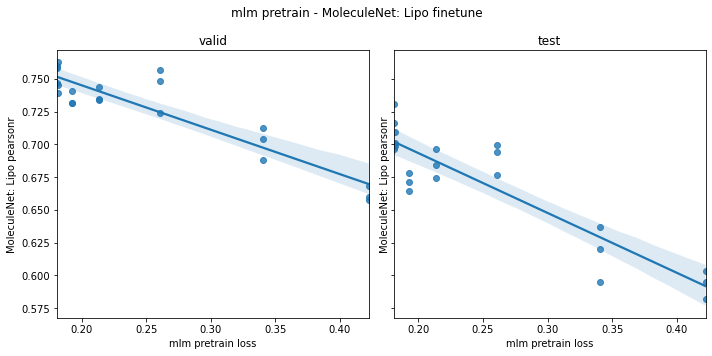

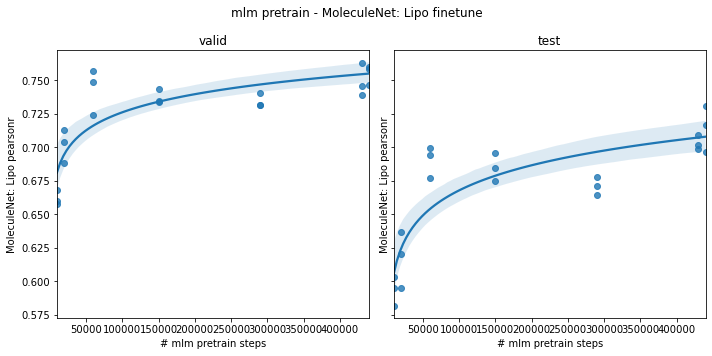

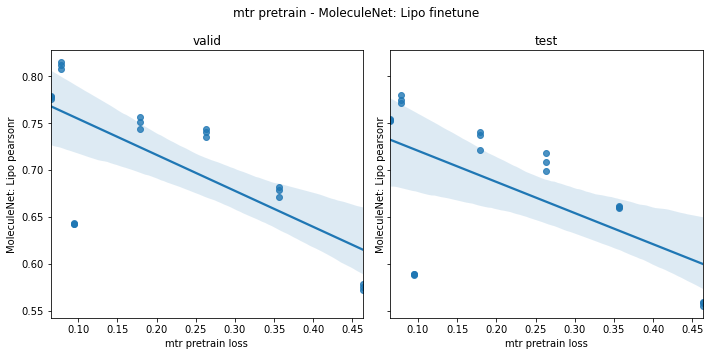

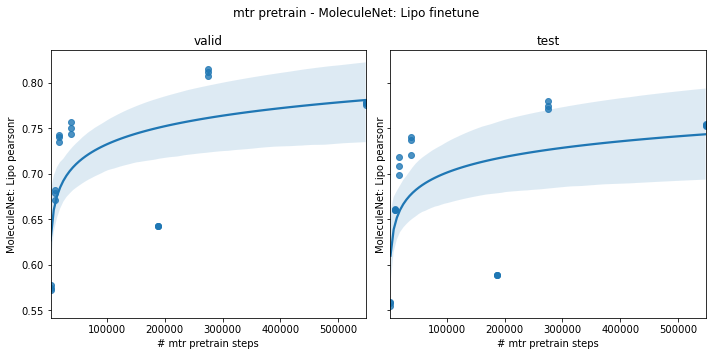

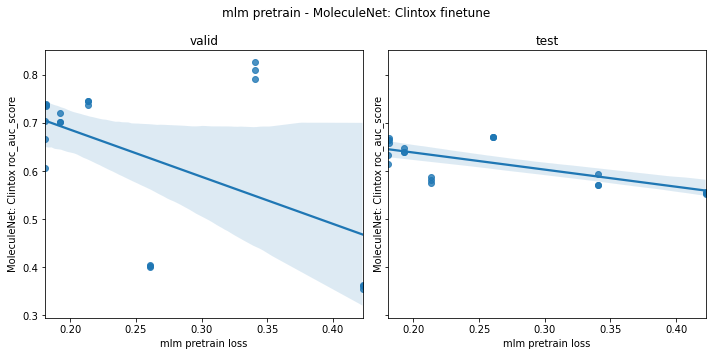

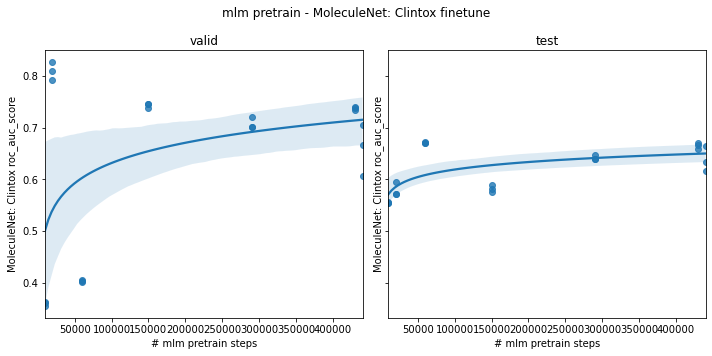

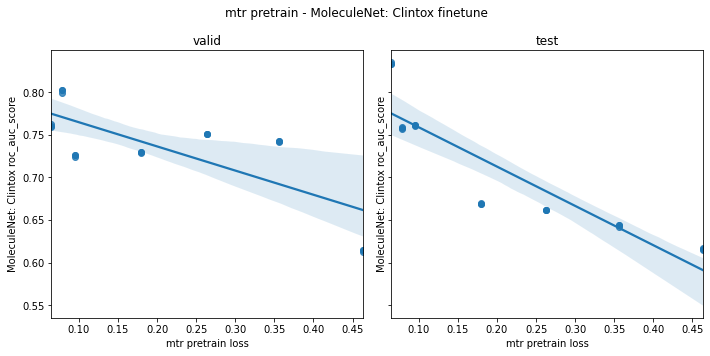

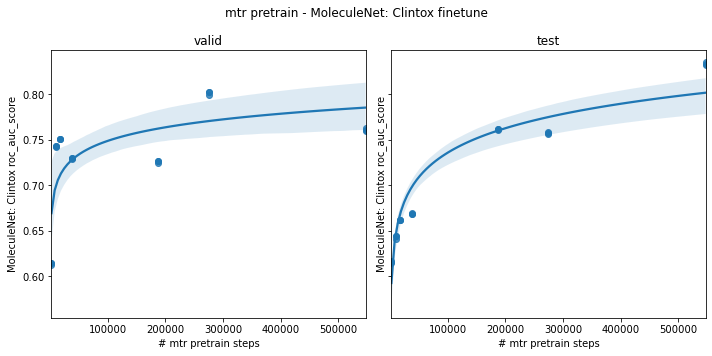

In [67]:
make_finetune_plots("finetune_molnet_over_time_2021-09-20", "pearsonr", "MoleculeNet: Delaney", "delaney")
make_finetune_plots("finetune_molnet_over_time_2021-09-20", "pearsonr", "MoleculeNet: Lipo", "lipo")
make_finetune_plots("finetune_molnet_over_time_2021-09-20", "roc_auc_score", "MoleculeNet: Clintox", "clintox")

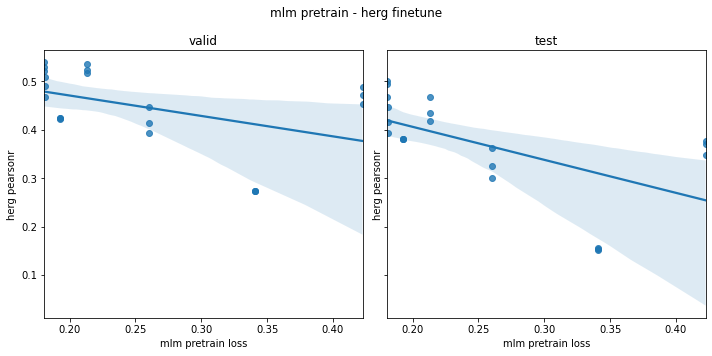

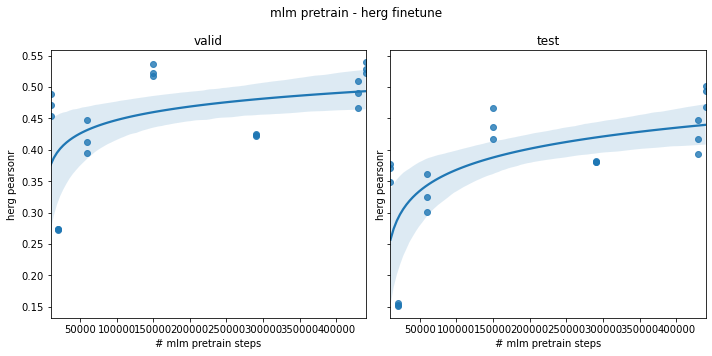

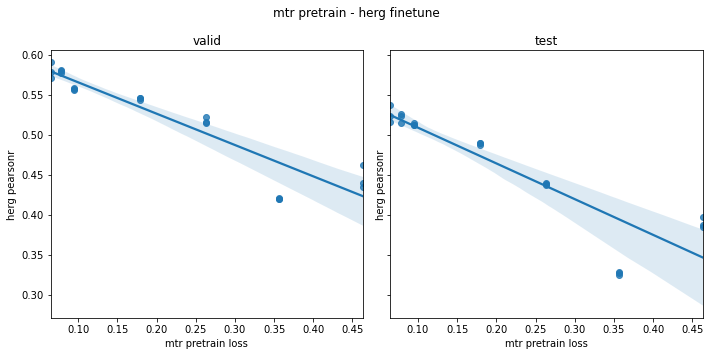

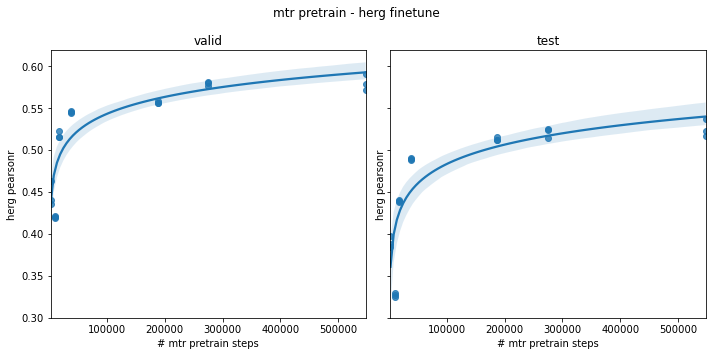

In [53]:
make_finetune_plots("finetune_molnet_over_time_2021-09-21", "pearsonr", "herg")

In [ ]:
pretrain_task = "mlm"
finetune_dir = ""
finetune_subdir = f"{finetune_dir}/{pretrain_task}"
finetune_res = get_pretrain_ckpt_to_finetune_loss(finetune_subdir, mlm_ckpts_to_eval, mlm_pretrain_loss, "")

In [94]:
pretrain_task = []
finetune_task = []
value = []
std = []

for task, molnet_res_path in [("mlm", "mlm_results.csv"), ("mtr", "mtr_5m_results.csv")]:
	res = pd.read_csv(molnet_res_path)
	best_run = res["min_eval_loss"].argmin()

	pretrain_task.append(task)
	finetune_task.append("clintox [avg pr]")
	value.append(res.loc[best_run, "clintox_test_average_precision_score_mean"])
	std.append(res.loc[best_run, "clintox_test_average_precision_score_std"])


	pretrain_task.append(task)
	finetune_task.append("delaney [rmse]")
	value.append(res.loc[best_run, "delaney_test_rmse_mean"])
	std.append(res.loc[best_run, "delaney_test_rmse_std"])

	pretrain_task.append(task)
	finetune_task.append("lipo [rmse]")
	value.append(res.loc[best_run, "lipo_test_rmse_mean"])
	std.append(res.loc[best_run, "lipo_test_rmse_std"])




In [95]:
molnet_res_df = pd.DataFrame({"pretrain_task": pretrain_task,
"finetune_task": finetune_task,
"value": value, "std": std})

In [104]:
molnet_res_df

,pretrain_task,finetune_task,value,std
0,mlm,clintox [avg pr],0.968323,0.000813
1,mlm,delaney [rmse],0.439621,0.005050
2,mlm,lipo [rmse],0.679080,0.015164
3,mtr,clintox [avg pr],0.975139,0.001115
4,mtr,delaney [rmse],0.464701,0.004622
5,mtr,lipo [rmse],0.593445,0.002481


Text(0.5, 1.0, 'Top MLM vs top MTR pre-trained models finetuned on MoleculeNet')

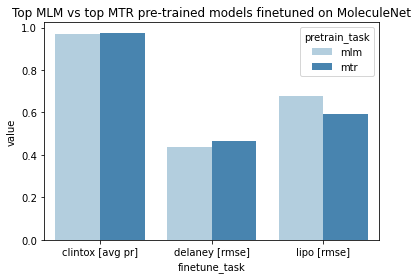

In [103]:
sns.barplot(data=molnet_res_df,x="finetune_task", y="value", ci="std", hue="pretrain_task", palette="Blues")
plt.title("Top MLM vs top MTR pre-trained models finetuned on MoleculeNet")